In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import arviz as az

from scipy.stats import invwishart, invgamma
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import functions as func

az.style.use("arviz-darkgrid")

In [2]:
%load_ext autoreload
%autoreload 2

## Load the data

In [3]:
df = pd.read_pickle("2023-10.pkl")
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

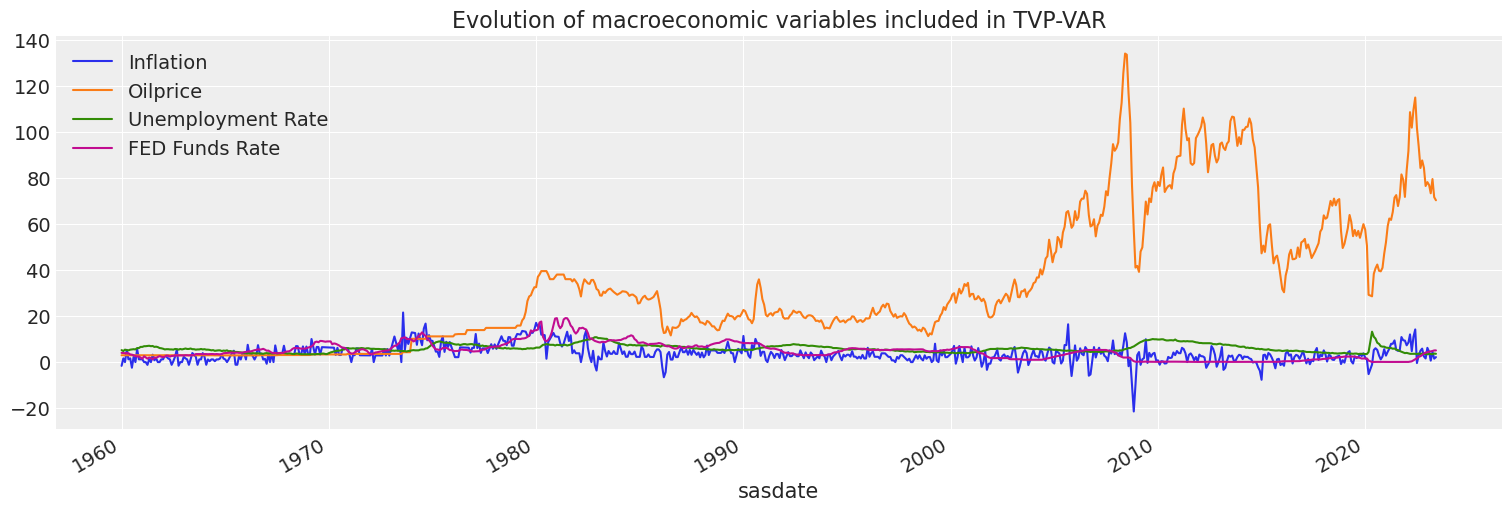

In [4]:
tvp_y = df[['inflation', 'OILPRICEx', 'UNRATE', 'FEDFUNDS']].copy()
tvp_y = tvp_y.dropna()
tvp_y = tvp_y.rename(columns={'inflation': 'Inflation', 'OILPRICEx': 'Oilprice', 'UNRATE': 'Unemployment Rate', 'FEDFUNDS': 'FED Funds Rate'})

fig, ax = plt.subplots(figsize=(15, 5))
tvp_y.plot(ax=ax)
ax.set_title('Evolution of macroeconomic variables included in TVP-VAR');

In [5]:
non_stat = func.get_non_stat_vars(tvp_y)
print(f"Differencing non-stationary variables: {non_stat}")
tvp_y[non_stat] = tvp_y[non_stat].diff()
tvp_y = tvp_y.dropna()

Differencing non-stationary variables: ['Oilprice']


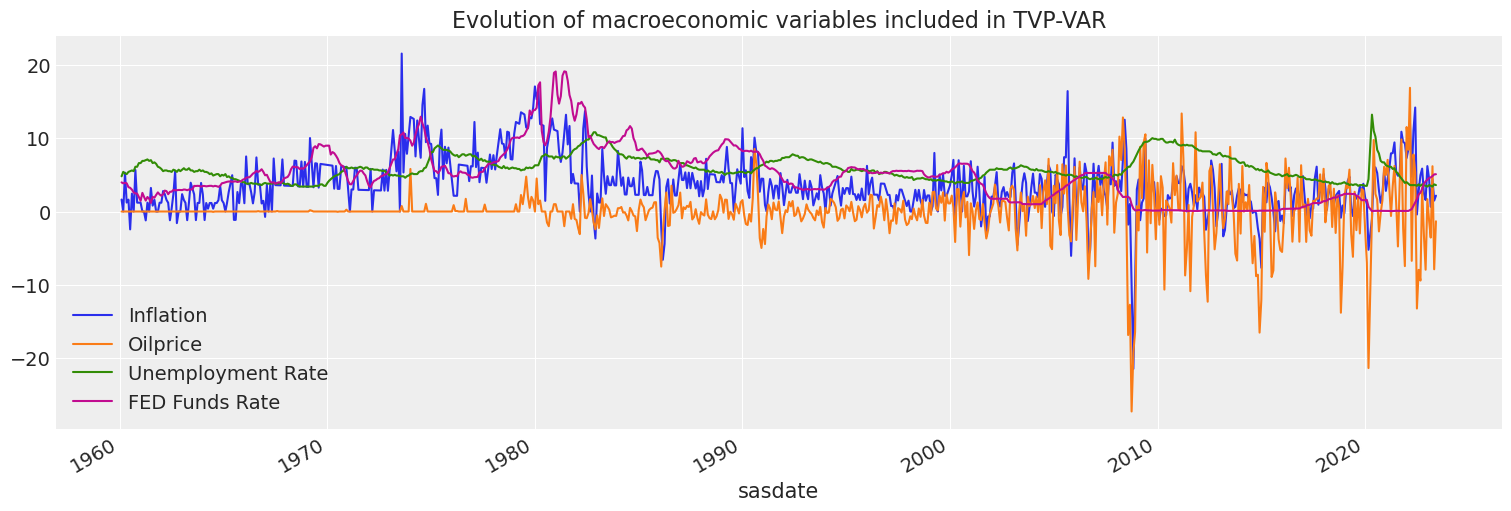

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
tvp_y.plot(ax=ax)
ax.set_title('Evolution of macroeconomic variables included in TVP-VAR');

In [7]:
y_centered = tvp_y.subtract(tvp_y.mean())

## Model setup

$y_t = Z_t \alpha_t + \varepsilon_t, \quad \varepsilon_t \sim N\left(0, H\right) \\$
$\alpha_{t+1} = \alpha_t + \eta_t, \quad \eta_t \sim N\left(0, diag(\sigma^2_i)\right)$.

In [8]:
tvp_mod = func.TVPVAR(y_centered)

# Set initial values for observation cov H and state cov diag(\sigma^2)
initial_obs_cov = np.cov(y_centered.T)
initial_state_cov_diag = [0.01] * tvp_mod.k_states

# Initial simulation smoother
tvp_mod.update_variances(initial_obs_cov, initial_state_cov_diag)
initial_res = tvp_mod.smooth([])

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
def plot_coefficients_by_equation(states, var_titles):
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    fig.suptitle('Time-Varying Coefficients per equation')
    
    for i, title in enumerate(var_titles):
        ax = axes[i//2, i%2]
        states.iloc[:, i*5:(i+1)*5].plot(ax=ax)
        ax.set_title(f'{title}')
        ax.legend(fontsize = 8)
        
    # fig.savefig('coefficients_by_equation.png', dpi=150)

    return ax

### Plot smoothed states

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:2998: ValueWarning: No supported index is available. The `states` DataFrame uses a generated integer index
  warnings.warn('No supported index is available. The `states`'


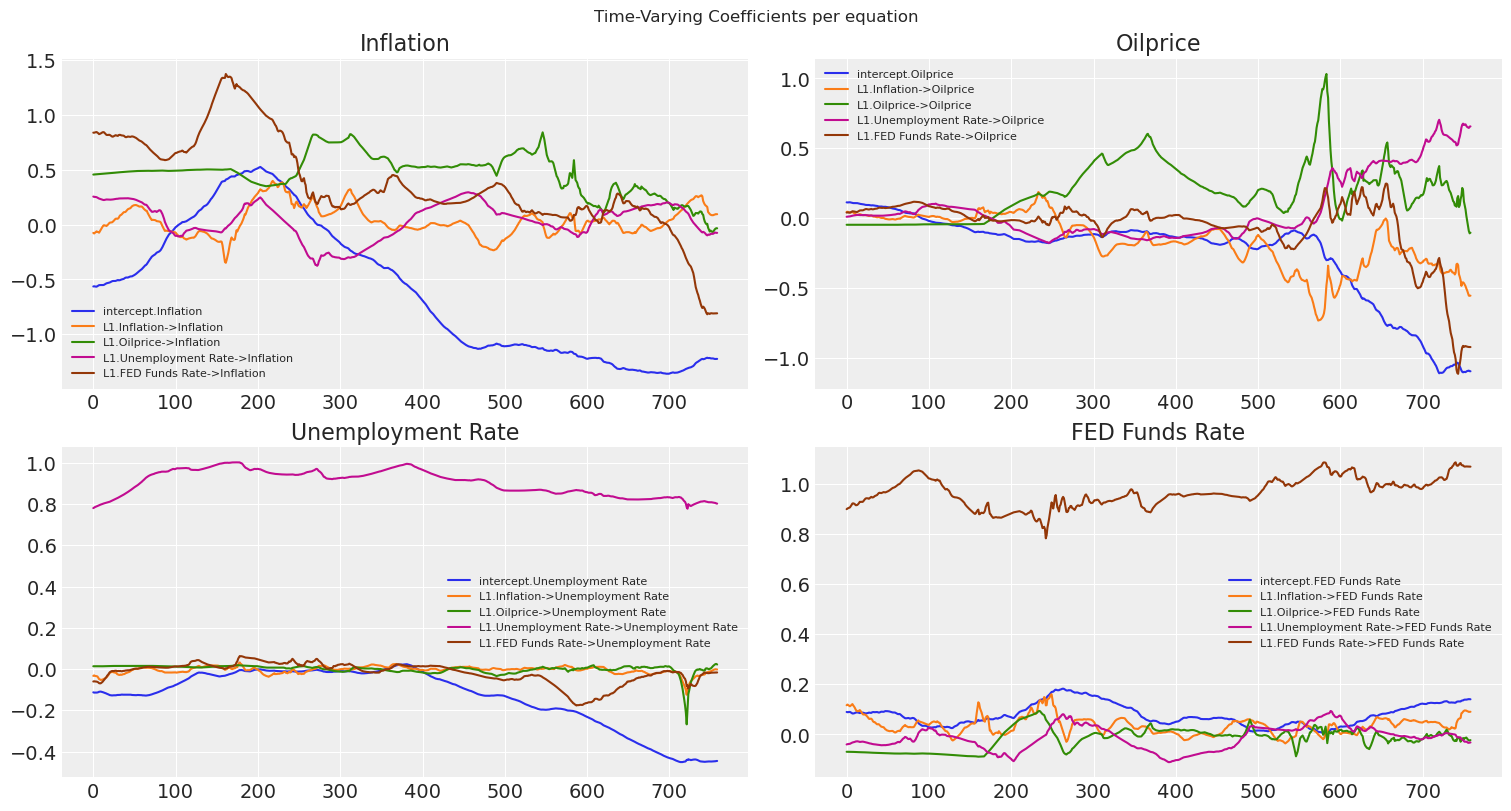

In [10]:
plot_coefficients_by_equation(initial_res.states.smoothed, tvp_y.columns);

## Gibbs Sampling

Prior for observation cov $H \sim$ inv-Wishart $\left(v_1^0=k + 3, S_1^0=I \right)\\$ 
Prior for state cov. variances $\sigma^2_i \sim \Gamma^{-1} \left( \frac{v_{i2}^0}{2} = 3, \frac{S_{i2}^0}{2} = 0.005 \right)$

In [11]:
# Prior for obs. cov.
v10 = tvp_mod.k_endog + 3
S10 = np.eye(tvp_mod.k_endog)

# Prior for state cov. variances
vi20 = 6
Si20 = 0.01

Sample $[\alpha|y, H, diag(\sigma_i^2)] \sim N(\hat{\alpha}, P^{-1})$, where mean $\hat{\alpha} = P^{-1} Z^{\prime} (I \otimes H^{-1})y$ and $P$ is the precision obtained via CFA. 

Sample $[H|y, \alpha] \sim IW\left( \nu_1^0 + T, S_1^0 + \sum^T_{t=1} (y_t - Z_t \alpha_t)(y_t - Z_t \alpha_t)^{\prime} \right).$

Sample $[diag(\sigma_i^2)|y, \alpha]$ from independent Gamma distributions for all $i$ as 
    $[\sigma_i^2|y, \alpha] \sim \Gamma^{-1}\left( \frac{\nu_{i 2}^0 + T - 1}{2}, \frac{S_{i 2}^0}{2} + \sum^T_{t=2} (\alpha_{t,i} - \alpha_{t-1,i})^2 \right), \textbf{ } \forall \textbf{ } i$

In [12]:
# Gibbs sampler setup
niter = 11000
nburn = 1000
h = 12

# Create storage arrays
store_states = np.zeros((niter + 1, tvp_mod.nobs, tvp_mod.k_states))
store_obs_cov = np.zeros((niter + 1, tvp_mod.k_endog, tvp_mod.k_endog))
store_state_cov = np.zeros((niter + 1, tvp_mod.k_states))
store_forecasts = np.zeros((niter + 1, h, tvp_mod.k_endog))

# Initialize
store_obs_cov[0] = initial_obs_cov
store_state_cov[0] = initial_state_cov_diag
tvp_mod.update_variances(store_obs_cov[0], store_state_cov[0])

# Construct posterior sampler using Cholesky Factor Algorithm
sim = tvp_mod.simulation_smoother(method='cfa')

In [13]:
for i in range(niter):
    tvp_mod.update_variances(store_obs_cov[i], store_state_cov[i])
    sim.simulate()

    # Draw from conditional posterior of the states alpha using CFA
    store_states[i + 1, :, :] = sim.simulated_state.T

    # Sample forecasts
    store_forecasts[i + 1, :, :] = tvp_mod.simulate([store_obs_cov[i], store_state_cov[i]], h, initial_state=store_states[i + 1][-1])

    # Simulate observation covariance matrix H from IW
    fitted = np.matmul(tvp_mod['design'].transpose(2, 0, 1), store_states[i + 1][..., None])[..., 0]
    resid = tvp_mod.endog - fitted
    store_obs_cov[i + 1, :, :] = invwishart.rvs(v10 + tvp_mod.nobs, S10 + resid.T @ resid)

    # Simulate state cov variances sigma^2 from IG
    resid = store_states[i + 1, 1:] - store_states[i + 1, :-1]
    sse = np.sum(resid**2, axis=0)
    
    for j in range(tvp_mod.k_states):
        rv = invgamma.rvs((vi20 + tvp_mod.nobs - 1) / 2, scale=(Si20 + sse[j]) / 2)
        store_state_cov[i + 1, j] = rv

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1692: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  params = np.array(params, ndmin=1)
/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1692: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  params = np.array(params, ndmin=1)
/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/

## Forecasts

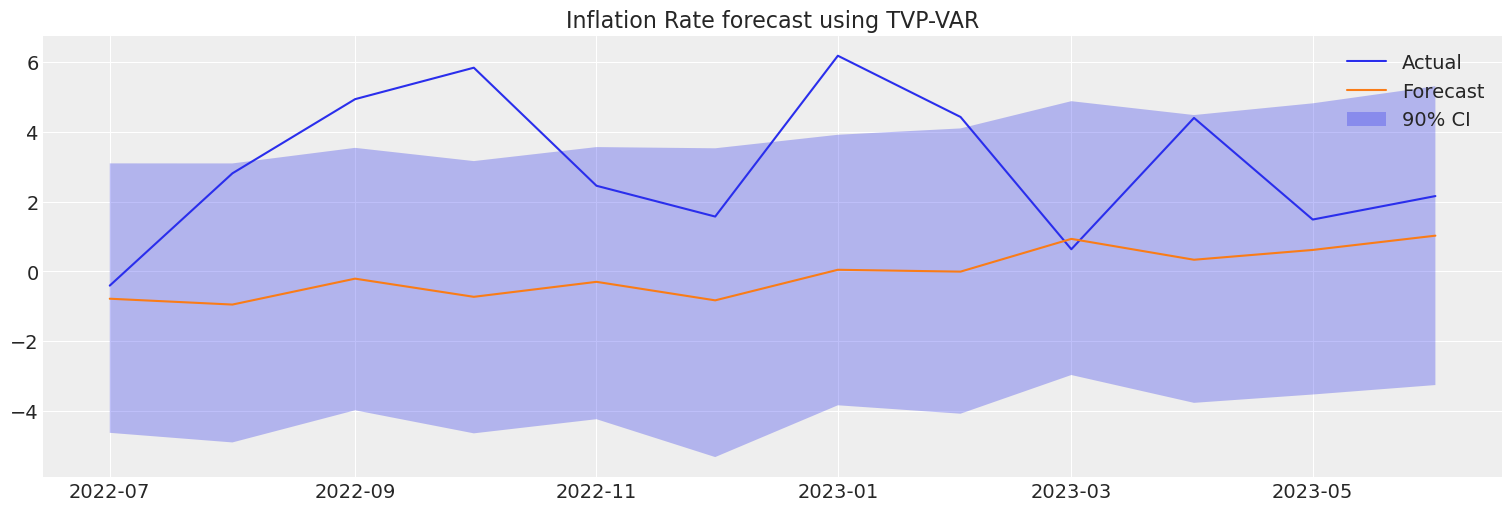

In [14]:
mean_forecasts = np.mean(store_forecasts[nburn+1:,:,:], axis=0)
lower_forecasts = np.percentile(store_forecasts[nburn+1:,:,:], 5, axis=0)
upper_forecasts = np.percentile(store_forecasts[nburn+1:,:,:], 95, axis=0)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(tvp_y.loc["2022-07-01":,'Inflation'], label='Actual')
ax.plot(tvp_y.loc["2022-07-01":,'Inflation'].index, mean_forecasts[:,0], label='Forecast')
ax.fill_between(tvp_y.loc["2022-07-01":,'Inflation'].index, lower_forecasts[:,0], upper_forecasts[:,0], alpha=0.3, label='90% CI')
ax.legend()
ax.set_title('Inflation Rate forecast using TVP-VAR');

In [15]:
print("Forecast")
print('MSE:', mean_squared_error(tvp_y.loc["2022-07-01":,'Inflation'], mean_forecasts[:,0]))
print('MAE:', mean_absolute_error(tvp_y.loc["2022-07-01":,'Inflation'], mean_forecasts[:,0]))
print('R2:', r2_score(tvp_y.loc["2022-07-01":,'Inflation'], mean_forecasts[:,0]))
print("-"*50)

Forecast
MSE: 14.463885595369561
MAE: 3.1652156671552927
R2: -2.572508116837454
--------------------------------------------------


### Plot the posterior samples for H and $\sigma^2_i$

In [16]:
# Collect the state_cov and obs_cov posterior samples
state_cov_posterior = store_state_cov[nburn+1:]
obs_cov_posterior = store_obs_cov[nburn+1:]

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_25600/2667560519.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


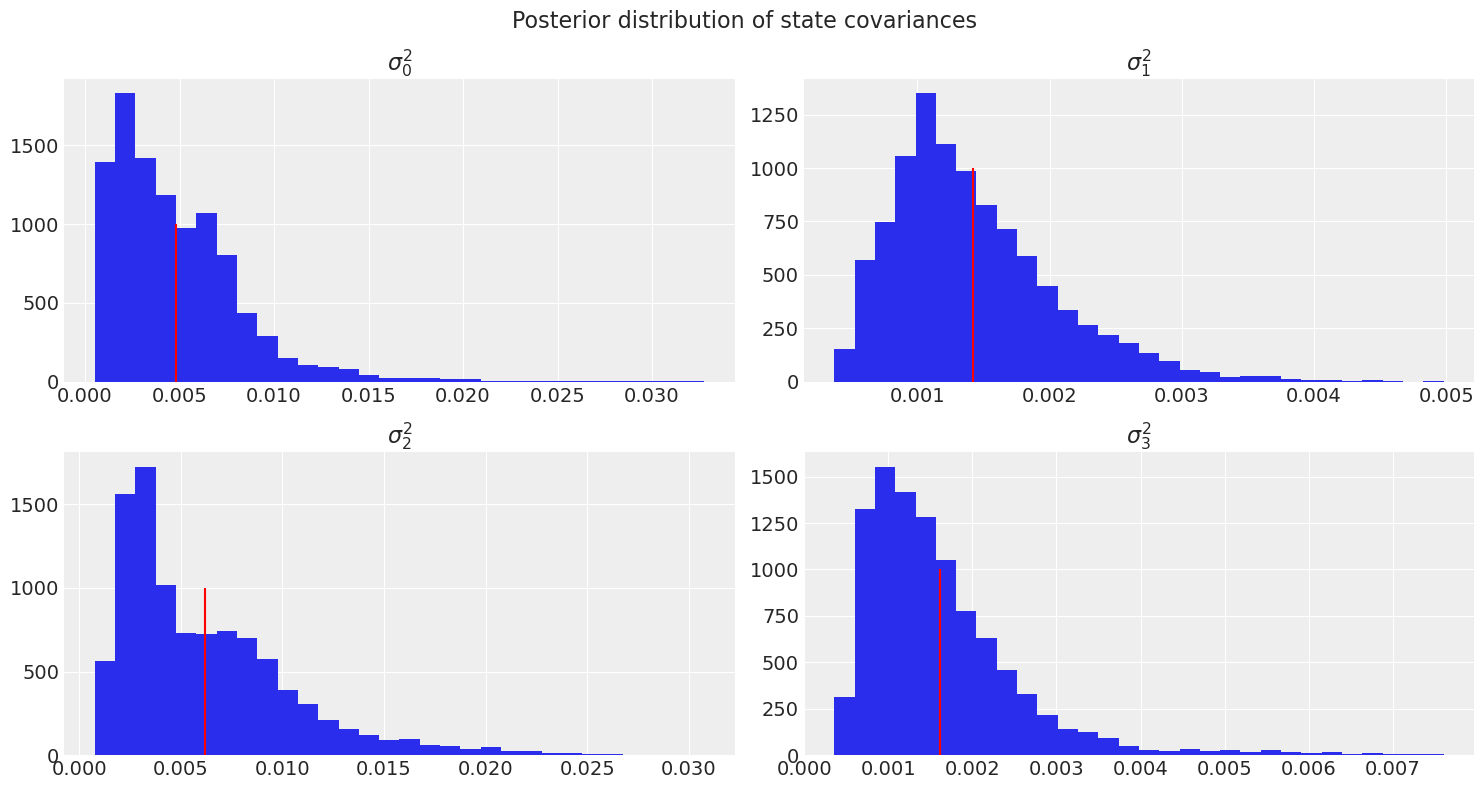

In [17]:
# Plot the posterior distribution of the state covariances \sigma^2_i
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Posterior distribution of state covariances', fontsize=16)
axes = axes.flatten()
titles = ['Inflation Rate', 'Oilprice', 'Unemployment Rate', 'Invest (Bank Credit Securities)']

for i in range(4):
    ax = axes[i]
    ax.hist(state_cov_posterior[:, i], bins=30)
    ax.vlines(state_cov_posterior[:, i].mean(), color='red', label='Mean', ymin=0, ymax=1000)
    ax.set_title(f'$\sigma^2_{i}$')

plt.tight_layout()

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_25600/50061006.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


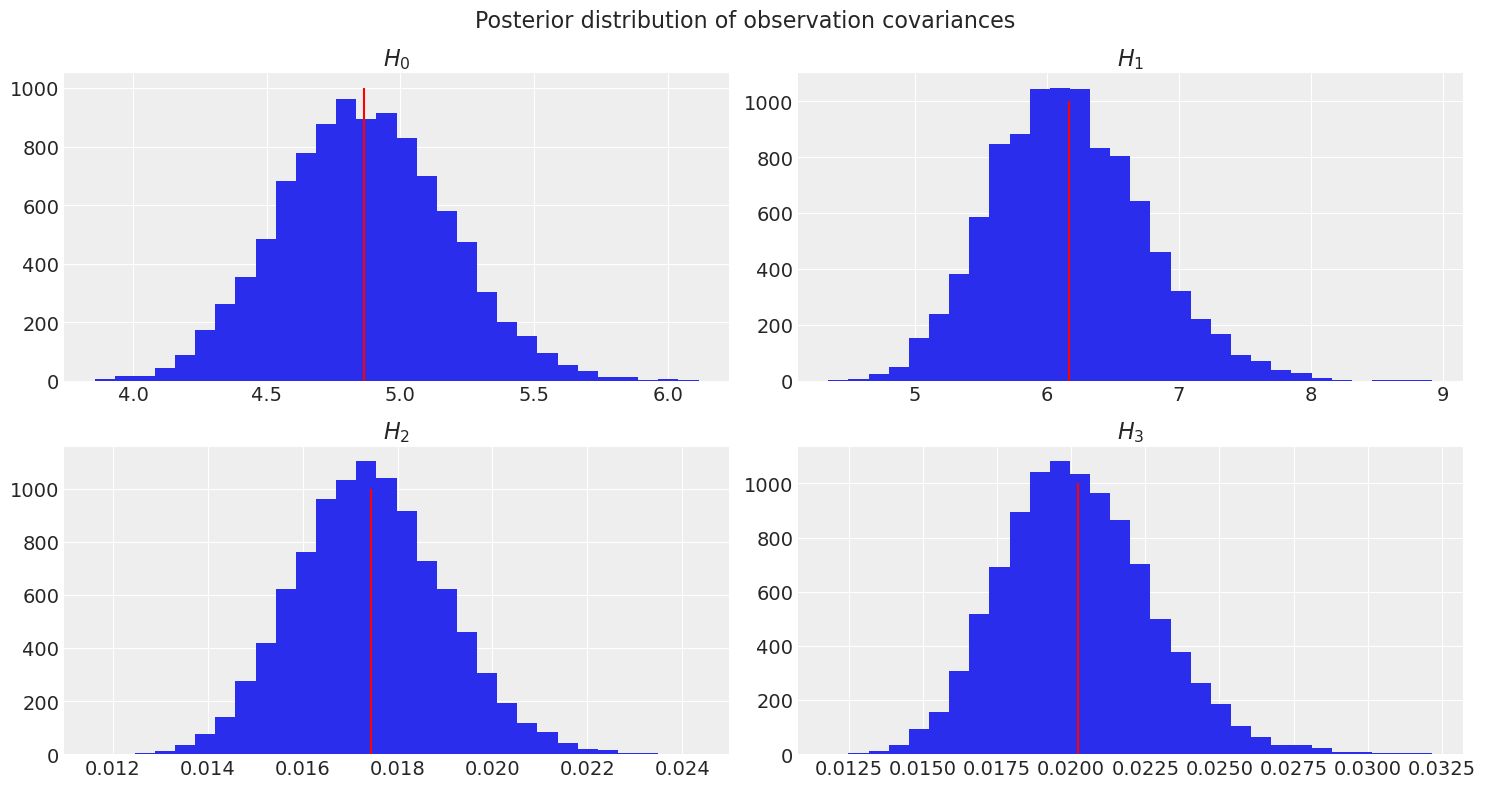

In [18]:
# Plot the posterior distribution of the observation covariances H_i
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Posterior distribution of observation covariances', fontsize=16)
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    ax.hist(obs_cov_posterior[:, i, i], bins=30)
    ax.vlines(obs_cov_posterior[:,i, i].mean(), color='red', label='Mean', ymin=0, ymax=1000)
    ax.set_title(f'$H_{i}$')

plt.tight_layout()

### Plot the posterior means of the time-varying coefficients

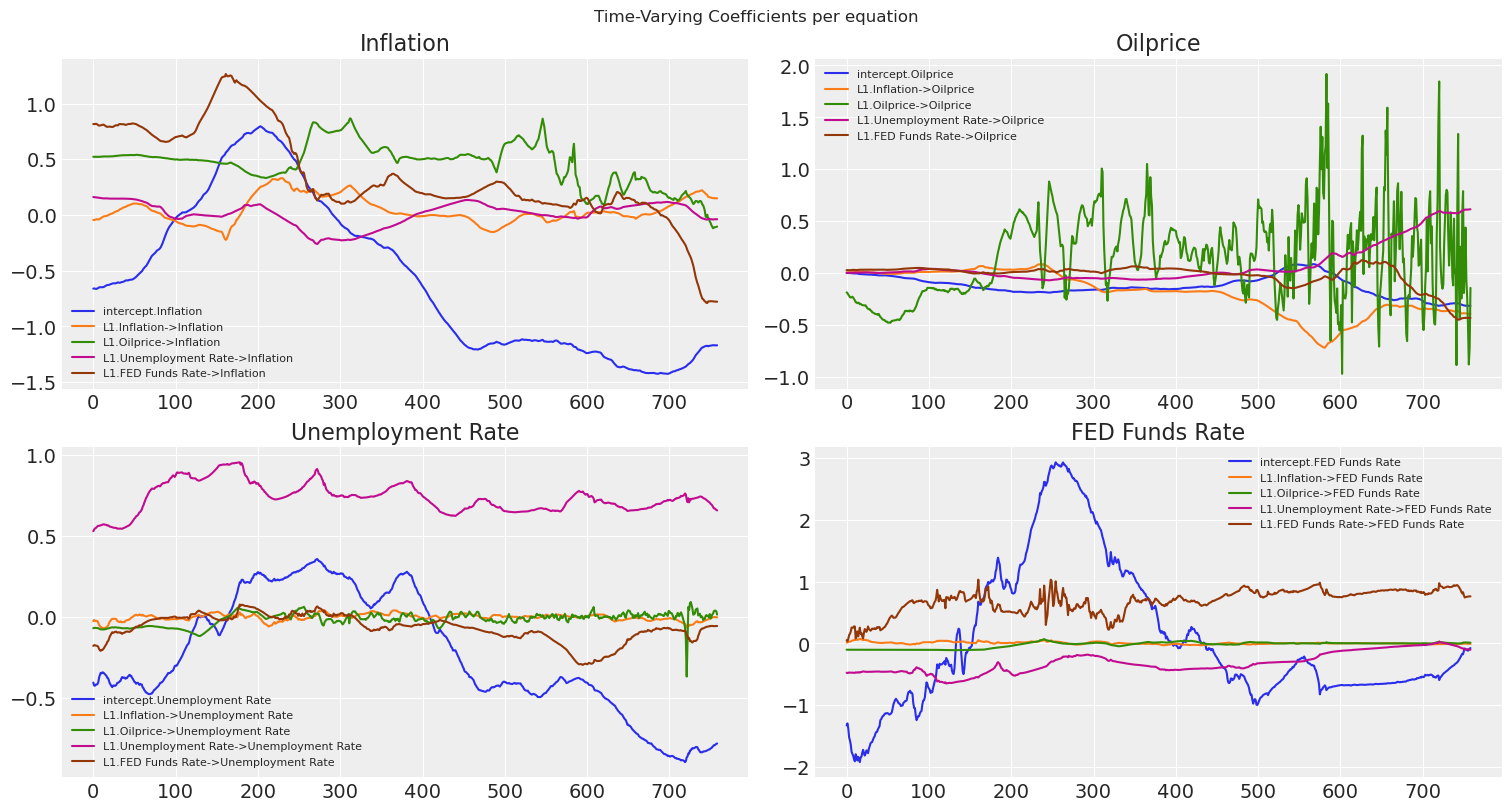

In [19]:
states_posterior_mean = pd.DataFrame(np.mean(store_states[nburn + 1:], axis=0), index=tvp_mod._index, columns=tvp_mod.state_names)
plot_coefficients_by_equation(states_posterior_mean, tvp_y.columns);
plt.savefig('coefficients_by_equation.png', dpi=150)

### Get fitted values

In [20]:
y_hat_tvp = np.matmul(tvp_mod['design'].transpose(2, 0, 1), states_posterior_mean.values[..., None])[..., 0]
y_hat_tvp = np.insert(y_hat_tvp, 0, [np.NaN,np.NaN,np.NaN,np.NaN], axis=0)
tvp_fitted = pd.DataFrame(y_hat_tvp, columns=tvp_y.columns, index=tvp_y.index)

tvp_fitted

Inflation  Oilprice  Unemployment Rate  FED Funds Rate
sasdate                                                           
1960-02-01        NaN       NaN                NaN             NaN
1960-03-01  -1.472105 -0.061508          -0.788261       -0.855301
1960-04-01  -1.401215 -0.107624          -0.456150       -1.113107
1960-05-01  -1.607888  0.033244          -0.699005       -1.052876
1960-06-01  -1.513495 -0.070859          -0.628007       -1.314151
...               ...       ...                ...             ...
2023-02-01  -0.511930 -2.998389          -2.407431       -0.219135
2023-03-01  -0.644970 -1.225033          -2.387149       -0.095866
2023-04-01  -1.021671  2.662662          -2.517402        0.006235
2023-05-01  -1.646007 -6.495720          -2.251754        0.263721
2023-06-01  -0.791346  0.195179          -2.350492        0.286290

[760 rows x 4 columns]

In [23]:
# Add mean back to the fitted values to get the uncentered values
tvp_fitted['inflation+mean'] = tvp_fitted['Inflation'] + tvp_y['Inflation'].mean()
tvp_fitted['Oilprice+mean'] = tvp_fitted['Oilprice'] + tvp_y['Oilprice'].mean()
tvp_fitted['Unemployment Rate+mean'] = tvp_fitted['Unemployment Rate'] + tvp_y['Unemployment Rate'].mean()
tvp_fitted["FED Funds Rate+mean"] = tvp_fitted['FED Funds Rate'] + tvp_y['FED Funds Rate'].mean()

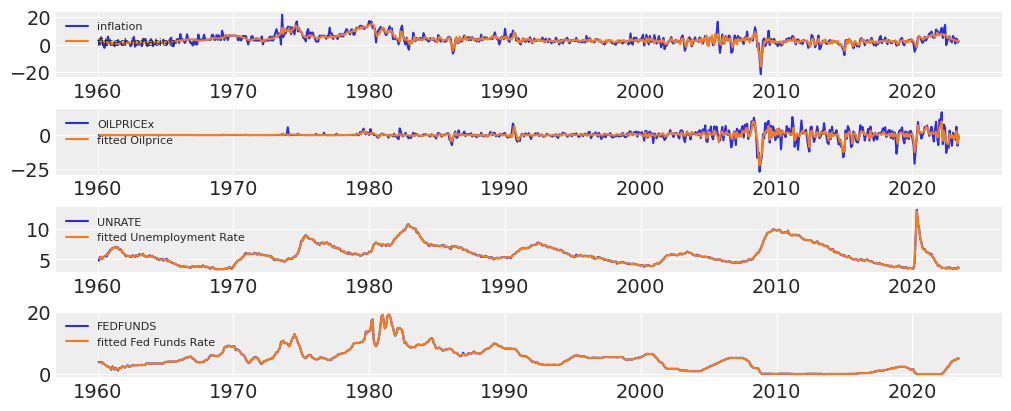

In [24]:
fig, ax = plt.subplots(4,1,figsize=(10, 4))
ax[0].plot(tvp_y.index, tvp_y["Inflation"], label='inflation')
ax[1].plot(tvp_y.index, tvp_y["Oilprice"], label='OILPRICEx')
ax[2].plot(tvp_y.index, tvp_y["Unemployment Rate"], label='UNRATE')
ax[3].plot(tvp_y.index, tvp_y["FED Funds Rate"], label='FEDFUNDS')
ax[0].plot(tvp_fitted.index, tvp_fitted["inflation+mean"], label='fitted inflation')
ax[1].plot(tvp_fitted.index, tvp_fitted["Oilprice+mean"], label='fitted Oilprice')
ax[2].plot(tvp_fitted.index, tvp_fitted["Unemployment Rate+mean"], label='fitted Unemployment Rate')
ax[3].plot(tvp_fitted.index, tvp_fitted["FED Funds Rate+mean"], label='fitted Fed Funds Rate')
ax[0].legend(loc='upper left', fontsize=8)
ax[1].legend(loc='upper left', fontsize=8)
ax[2].legend(loc='upper left', fontsize=8)
ax[3].legend(loc='upper left', fontsize=8)

### Residuals

In [35]:
resid_infl = tvp_y.loc[:"2022-07-01",'Inflation'] - tvp_fitted.loc[:"2022-07-01",'inflation+mean']

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_25600/504795058.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


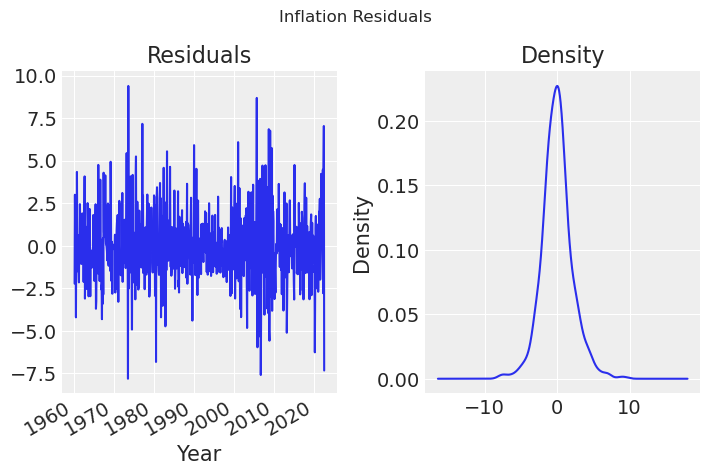

In [36]:
fig, ax = plt.subplots(1,2)
resid_infl.plot(title='Residuals', ax=ax[0])
ax[0].set_xlabel('Year')
resid_infl.plot(title='Density', kind='kde', ax=ax[1])
plt.suptitle('Inflation Residuals')
plt.tight_layout()
# plt.savefig('xgb_residuals.png', dpi=150)
plt.show()

### Intervals

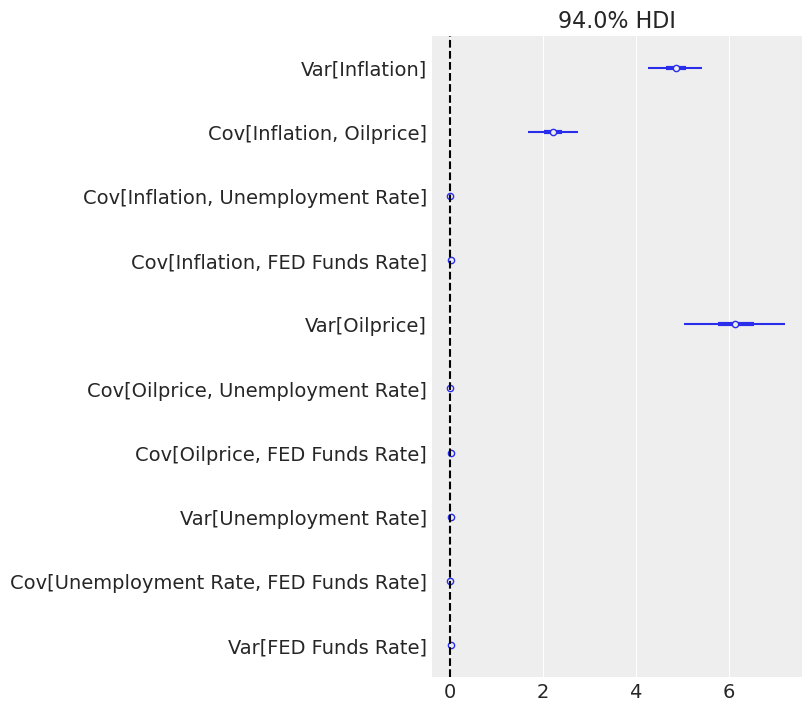

In [38]:
# Collect the observation error covariance parameters
az_obs_cov = az.convert_to_inference_data({
    ('Var[%s]' % tvp_mod.endog_names[i] if i == j else
     'Cov[%s, %s]' % (tvp_mod.endog_names[i], tvp_mod.endog_names[j])):
    store_obs_cov[nburn + 1:, i, j]
    for i in range(tvp_mod.k_endog) for j in range(i, tvp_mod.k_endog)})

# Plot the credible intervals
az.plot_forest(az_obs_cov, figsize=(8, 7));
plt.axvline(0, color="k", ls="--")

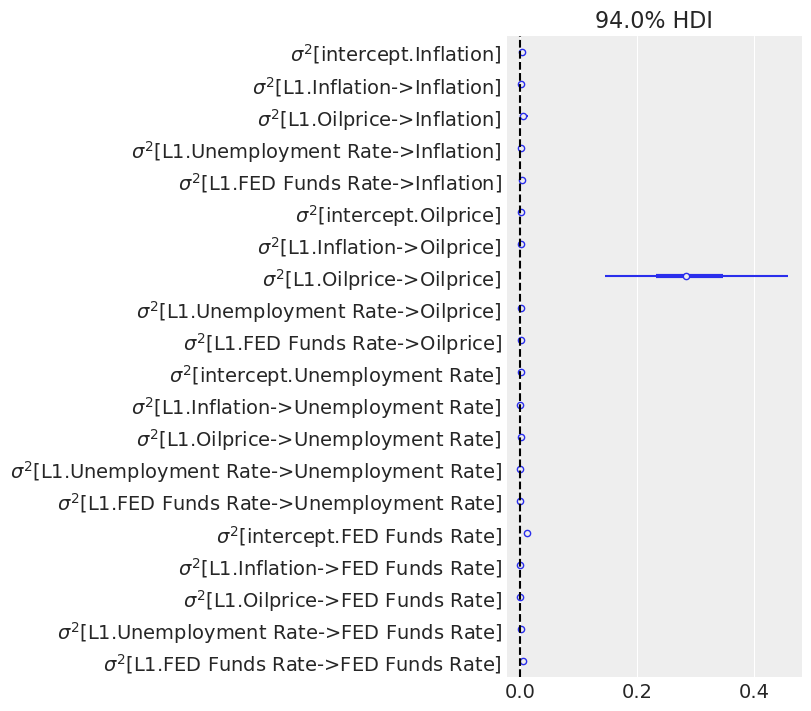

In [39]:
# Collect the state innovation variance parameters
az_state_cov = az.convert_to_inference_data({
    r'$\sigma^2$[%s]' % tvp_mod.state_names[i]: store_state_cov[nburn + 1:, i]
    for i in range(tvp_mod.k_states)})

# Plot the credible intervals
az.plot_forest(az_state_cov, figsize=(8, 7));
plt.axvline(0, color="k", ls="--")